In [ ]:
%pip install numpy pandas matplotlib scikit-learn scikit-image seaborn plotly timm albumentations torch torchvision torchaudio colorama segmentation-models-pytorch

In [ ]:
import numpy as np
import pandas as pd
# pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os
from tqdm import tqdm
tqdm.pandas()

from dataclasses import dataclass


# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Optimizer

# Albumentations for augmentations
import albumentations as A
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.pytorch import ToTensorV2


# Add Monitoring and Logging
import wandb
from datetime import datetime

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import userdata
WANDB_API_KEY = userdata.get('WANDB_API_KEY')
if not WANDB_API_KEY:
    raise ValueError("WANDB_API_KEY environment variable is not set.")

# ⚙️ Configuration

In [ ]:


@dataclass
class CFG:
    seed          = 2025
    backbone      = "efficientnet-b3"# "efficientnet-b3" # se_resnext101_32x4d - se_resnext50_32x4d - efficientnet-b3  timm-resnest101e
    decoder_attention_type = "scse"
    train_bs      = 3
    valid_bs      = train_bs*2
    img_size      = [1536, 786]
    crop_size     = [512, 512]
    epochs        = 40 # 40
    lr            = 1e-4
    max_grad_norm = 100
    scheduler     = "ReduceLROnPlateau" #'OneCycle' # ReduceLROnPlateau CosineAnnealingLR CustomCosineAnnealingWarmupRestarts
    min_lr        = 5e-5
    T_max         = int(17000/train_bs*epochs)+50
    T_0           = 25
    max_lr        = 4e-4
    warmup_epochs = 0
    wd            = 5e-6
    n_accumulate  = 1
    n_fold        = 4
    folds         = [0, 1, 2, 3]
    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    aux_head      = False
    thresh        = [0.3, 0.4, 0.5, 0.6, 0.7]


In [ ]:
# Initialize W&B run
wandb.login(key=WANDB_API_KEY)
run = wandb.init(
    project="tumor-segmentation",
    entity="nm-i-ki",
    name=f"train_unet_kfold_tta_{datetime.now():%Y%m%d_%H%M%S}",
    config={
        "seed": CFG.seed,
        "backbone": CFG.backbone,
        "decoder_attention_type": CFG.decoder_attention_type,
        "train_bs": CFG.train_bs,
        "valid_bs": CFG.valid_bs,
        "img_size": CFG.img_size,
        "crop_size": CFG.crop_size,
        "epochs": CFG.epochs,
        "lr": CFG.lr,
        "max_grad_norm": CFG.max_grad_norm,
        "scheduler": CFG.scheduler,
        "min_lr": CFG.min_lr,
        "T_max": CFG.T_max,
        "T_0": CFG.T_0,
        "max_lr": CFG.max_lr,
        "warmup_epochs": CFG.warmup_epochs,
        "wd": CFG.wd,
        "n_accumulate": CFG.n_accumulate,
        "n_fold": CFG.n_fold,
        "folds": CFG.folds,
        "num_classes": CFG.num_classes,
        "aux_head": CFG.aux_head,
        "thresh": CFG.thresh,
    },
    tags=["segmentation", "efficientnet"],
    save_code=True,
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# ❗ Reproducibility

In [ ]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('-> SEEDING DONE')

set_seed(CFG.seed)

-> SEEDING DONE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# CONTROLS_DIR = "/content/drive/MyDrive/data/raw/tumor-segmentation/controls/"
PATIENTS_DIR = "/content/drive/MyDrive/data/raw/tumor-segmentation/patients"

rows = []
data_df = pd.DataFrame(columns=['image_id', 'image_path', 'label_path', 'label'])

# Load the control images
# control_images = glob(os.path.join(CONTROLS_DIR, "imgs", "*.png"))
# for img_path in control_images:
    # image_id = os.path.basename(img_path).split('/')[-1]
    # rows.append({'image_id': image_id, 'image_path': f'{CONTROLS_DIR}/imgs/{image_id}', 'label_path': '', 'label': 0})

# Load the patient images
patient_images = glob(os.path.join(PATIENTS_DIR, "imgs", "*.png"))
segmentation_labels = glob(os.path.join(PATIENTS_DIR, "labels", "*.png"))
for img_path, label_path in zip(patient_images, segmentation_labels):
    image_id = os.path.basename(img_path).split('/')[-1]
    label_id = image_id.replace('patient', 'segmentation')
    rows.append({'image_id': image_id, 'image_path': f'{PATIENTS_DIR}/imgs/{image_id}', 'label_path': f'{PATIENTS_DIR}/labels/{label_id}', 'label': 1})

data_df = pd.DataFrame(rows)
data_df = data_df.reset_index(drop=True)

Mounted at /content/drive


## Class Distribution

In [ ]:
df = data_df.copy()
df['label'].value_counts()

,count
label,
1,182


# 🔨 Utility

In [ ]:
def load_img(image_path, mask_path, scale = True):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (CFG.img_size[1], CFG.img_size[0]), interpolation=cv2.INTER_LINEAR)
    if mask_path == "":
        mask = np.zeros_like(img, dtype=np.uint8)
    else:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (CFG.img_size[1], CFG.img_size[0]), interpolation=cv2.INTER_LINEAR)
        mask = (mask > 0).astype(np.uint8)

    img = np.expand_dims(img.astype("float32"), axis=-1)
    mask = np.expand_dims(mask.astype("float32"), axis=-1)
    if scale:
        img = (img - img.min()) / (img.max() - img.min())
        # img = (img - img.mean()) / img.std()
    assert img.shape == mask.shape, f"Image shape {img.shape} does not match mask shape {mask.shape}"
    return img, mask


def get_dice(preds, masks, threshold=0.5, epsilon=1e-6):
    """
    Compute per-image Dice coefficient and return the mean across the batch.

    preds, masks: np.ndarray of shape (B, H, W) or (B, 1, H, W)
    """
    preds = (preds > threshold).astype(np.uint8)
    masks = (masks > threshold).astype(np.uint8)

    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds[:, 0]
        masks = masks[:, 0]

    intersection = (preds & masks).sum(axis=(1, 2))
    total = preds.sum(axis=(1, 2)) + masks.sum(axis=(1, 2))

    dice_scores = (2.0 * intersection + epsilon) / (total + epsilon)
    return dice_scores.mean()



# 📁 Create Folds

In [ ]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold,(train_idx, val_idx) in enumerate(skf.split(df, df['label'], df['image_id'])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','label'])['image_id'].count())

,,image_id
fold,label,
0.0,1,46
1.0,1,46
2.0,1,45
3.0,1,45


# 🍚 Dataset

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self,
                 df,
                 transforms=None):

        self.df           = df.reset_index(drop=True)
        self.transforms   = transforms
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.image_path[index]
        label_path = self.df.label_path[index]

        ## Load the image (RGB)
        img, mask = load_img(img_path, label_path, True)
        ## Apply Augmentations:
        if self.transforms:
            data = self.transforms(image=img, mask=mask)
            img  = data['image']
            mask = data['mask']
            img = np.transpose(img, (2, 0, 1))
        else:
            img = np.transpose(img, (2, 0, 1))

        mask = np.transpose(mask, (2, 0, 1))

        # if CFG.aux_head and self.label:
        #     labels = np.where(mask.sum((1, 2)) > 0, 1, 0)
        # else:
        #     labels = mask
        img = torch.tensor(img)
        mask = torch.tensor(mask)
        return torch.tensor(img), torch.tensor(mask), img_path


class TTADataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, tta_transforms):
        self.base_dataset = base_dataset
        self.tta_transforms = tta_transforms

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, mask, img_path = self.base_dataset[idx]

        image = image.permute(1, 2, 0).numpy()

        all_aug_images = []
        for t in self.tta_transforms:
            aug = t(image=image)['image']
            aug = torch.from_numpy(aug).permute(2, 0, 1).float()  # back to CHW
            all_aug_images.append(aug)

        return torch.stack(all_aug_images), mask, img_path

# Augmentations

In [ ]:
data_transforms = {"train": A.Compose([A.HorizontalFlip(p=0.5),
                                       A.VerticalFlip(p=0.5),
                                       A.RandomBrightnessContrast(brightness_limit=[-0.5, 0.5],contrast_limit=[0,0],p=0.5),
                                       A.GaussianBlur(sigma_limit=[0.2, 0.7],p=0.5),
                                       A.GaussNoise(std_range=[0.01,0.3],per_channel=False,noise_scale_factor=1.0,p=0.5),
                                    #    A.ShiftScaleRotate(rotate_limit=25, scale_limit=0.15, shift_limit=0, p=0.25),
#                                        A.CoarseDropout(max_holes=16, max_height=64 ,max_width=64 ,p=0.5),
#                                        A.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25, p=0.75),
#                                        A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, p=0.5),
                                       # A.RandomCrop(height=CFG.img_size[0], width=CFG.img_size[1], always_apply=True, p=1),
                                       # A.Normalize(p=1)
                                        ]),

                    "valid": A.Compose([]),#PadToDivisible(divisible=32, always_apply=True, p=1.0),

                    "tta": [
                        A.Compose([]),  # identity
                        A.HorizontalFlip(p=1.0),
                        A.VerticalFlip(p=1.0)
                     ]
                    }

# DataLoader

In [ ]:
def prepare_loaders(fold, non_empty=False):
    train_df = df[df.fold != fold].reset_index(drop=True)
    valid_df = df[df.fold == fold].reset_index(drop=True)

    if non_empty:
        train_df = train_df[train_df['label'] == 0].reset_index(drop=True)
        valid_df = valid_df[valid_df['label'] == 0].reset_index(drop=True)

    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    # Wrap the validation dataset in a deterministic TTA wrapper
    base_oof_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])
    oof_dataset = TTADataset(base_oof_dataset, tta_transforms=data_transforms['tta'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs,
                              num_workers=8, shuffle=True, pin_memory=True, drop_last=False)

    valid_loader = DataLoader(valid_dataset, batch_size=1,
                              num_workers=8, shuffle=False, pin_memory=True)

    oof_loader = DataLoader(oof_dataset, batch_size=1,  # returns [1, T, C, H, W]
                            num_workers=8, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, oof_loader, len(train_df) // CFG.train_bs, valid_df

In [ ]:
train_loader, valid_loader, oof_loader, training_steps, valid_df = prepare_loaders(fold=0)

In [ ]:
imgs, masks, path_ = next(iter(train_loader))

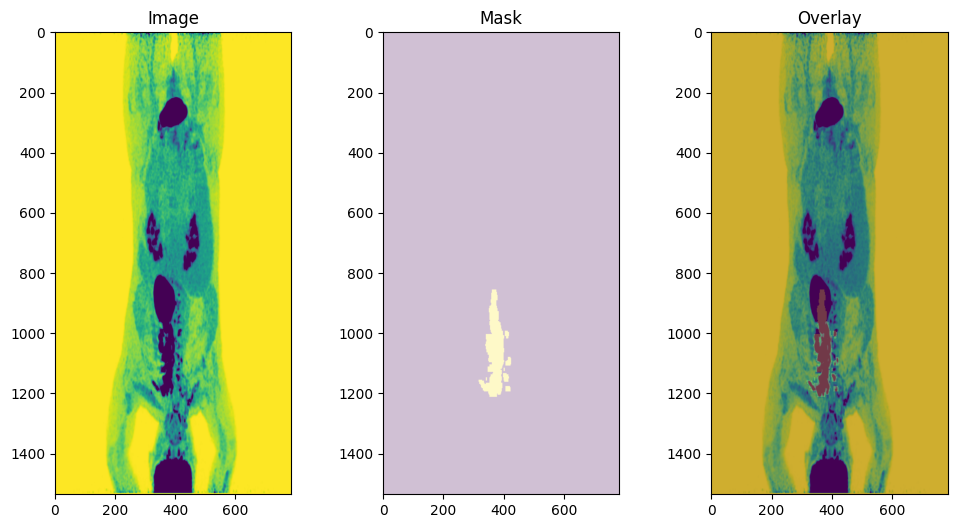

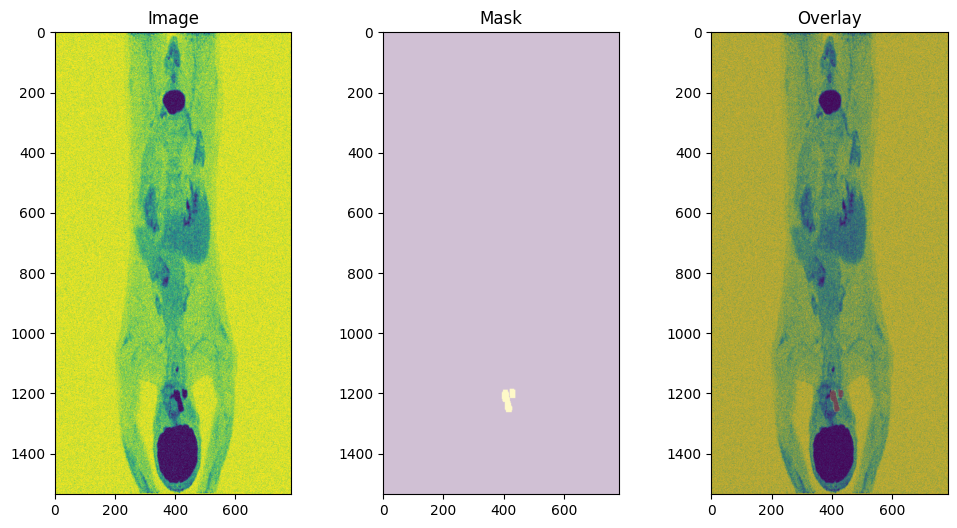

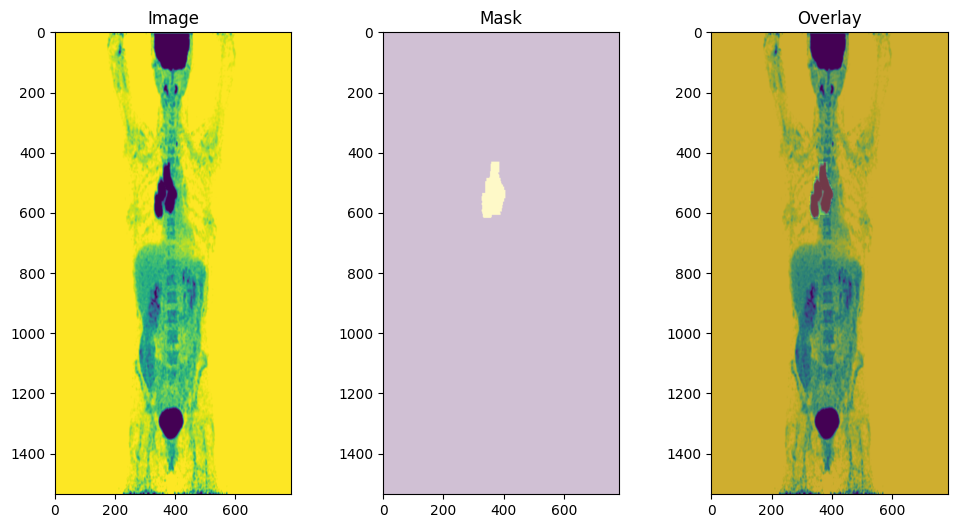

In [ ]:
for i in range(imgs.shape[0]):
    #make the image and mask two suplots horizontally with third image overlaying them together
    _img = np.transpose(imgs[i].cpu().numpy(), (1, 2, 0))
    mask = np.transpose(masks[i].cpu().numpy(), (1, 2, 0))
    fig, ax = plt.subplots(1,3, figsize=(12, 6))
    ax[0].imshow(_img)
    ax[0].set_title("Image")
    ax[1].imshow(mask, alpha = 0.25)
    ax[1].set_title("Mask")
    ax[2].imshow(_img)
    ax[2].imshow(mask, alpha = 0.25)
    ax[2].set_title("Overlay")
    plt.show()

In [ ]:
imgs, msks, paths_ = next(iter(valid_loader))

1.0 0.0
[0. 1.]


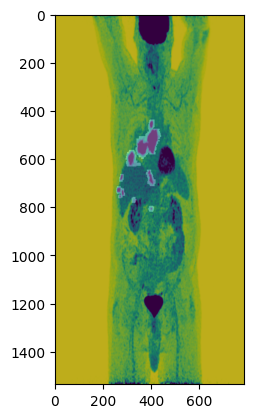

In [ ]:
for i in range(imgs.shape[0]):
    _img = np.transpose(imgs[i].cpu().numpy(), (1, 2, 0))
    _mask = np.transpose(msks[i].cpu().numpy(), (1, 2, 0))
    print(_img.max(), _img.min())
    print(np.unique(_mask))
    plt.imshow(_img)
    plt.imshow(_mask, alpha = 0.25, cmap = 'gray')
    plt.show()

In [ ]:
import gc
gc.collect()

21002

# 📦 Model

In [ ]:


def build_model():
    model = smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                     classes=1,                      # model output channels (number of classes in your dataset)
                     activation=None,
                     decoder_attention_type = CFG.decoder_attention_type, #"scse",
                     aux_params = None if not CFG.aux_head else {"classes": 1,
                                                                 "activation": None})
    model.to(CFG.device)
    return model


def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔧 Loss Function

In [ ]:
JaccardLoss    = smp.losses.JaccardLoss(mode='binary')
DiceLoss       = smp.losses.DiceLoss(mode='binary')
BCELoss        = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss     = smp.losses.LovaszLoss(mode='binary', per_image=False)
TverskyLoss    = smp.losses.TverskyLoss(mode='binary', log_loss=False, smooth=0.1)
SegFocalLoss   = smp.losses.FocalLoss(mode = 'binary')
BCE = torch.nn.BCEWithLogitsLoss()

def dice_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=1e-6):
    y_true = y_true.float()
    y_pred = (y_pred > thr).float()
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = (2 * inter + epsilon) / (den + epsilon)
    return dice.mean()  # mean over batch (and channel if present)


def iou_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=1e-6):
    y_true = y_true.float()
    y_pred = (y_pred > thr).float()
    inter = (y_true * y_pred).sum(dim=dim)
    union = y_true.sum(dim=dim) + y_pred.sum(dim=dim) - inter
    iou = (inter + epsilon) / (union + epsilon)
    return iou.mean()  # mean over batch


def criterion(y_pred, y_true):
    return DiceLoss(y_pred, y_true)

# def criterion(y_pred, y_true):
#     if CFG.aux_head:
#         y_true, yt_class = y_true
#         y_pred, yp_class = y_pred
#         return (0.5*DiceLoss(y_pred, y_true) + 0.5 * BCE(yp_class, yt_class))
#     return 0.5*DiceLoss(y_pred, y_true) + 0.5*SegFocalLoss(y_pred, y_true)

# 🚄 Training Function

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch:int):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    train_jaccards = []
    train_dices = []

    sigmoid = torch.sigmoid  # Faster than instantiating nn.Sigmoid()

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')

    optimizer.zero_grad()

    for step, (images, masks, paths) in pbar:
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)
        loss.backward()

        y_pred = sigmoid(y_pred)

        train_dice = dice_coef(masks, y_pred).cpu().item()
        train_jaccard = iou_coef(masks, y_pred).cpu().item()
        train_dices.append(train_dice)
        train_jaccards.append(train_jaccard)

        if (step + 1) % CFG.n_accumulate == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler and CFG.scheduler not in ["ReduceLROnPlateau", "ExponentialLR"]:
                scheduler.step()

        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        wandb.log({'train_loss': running_loss, 'epoch': epoch})
        # W&B per-epoch training metrics
        current_lr = optimizer.param_groups[0]['lr']
        mem = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0

        pbar.set_postfix(loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         jac=np.mean(train_jaccards),
                         dice=np.mean(train_dices),
                         gpu_mem=f'{mem:0.2f} GB')

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, np.mean(train_dices), np.mean(train_jaccards)


# 👀 Validation Function

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, optimizer, epoch:int):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    global_masks = []
    global_preds = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')

    for step, (images, masks, paths) in pbar:
        images = images.float().to(device)
        masks = masks.float().to(device)
        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = torch.sigmoid(y_pred)
        global_masks.append(masks.cpu().numpy())
        global_preds.append(y_pred.detach().cpu().numpy())

        current_lr = optimizer.param_groups[0]['lr']
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpu_mem=f'{mem:0.2f} GB')

    # For sample images, take first example of last batch
    # Concatenate all batches
    global_masks = np.concatenate(global_masks, axis=0)
    global_preds = np.concatenate(global_preds, axis=0)
    global_dice = get_dice(global_preds, global_masks)

    # Log overall validation metrics
    wandb.log({'val_loss': epoch_loss, 'val_dice': global_dice, 'epoch': epoch})

    # For sample images, take first example of last batch
    img_np = images[0].cpu().permute(1,2,0).numpy()
    mask_np = masks[0].cpu().permute(1,2,0).numpy()
    pred_np = global_preds[-1][0].astype('float32') # Remove transpose as it's a single channel
    wandb.log({
        'input': wandb.Image(img_np, caption='input'),
        'mask': wandb.Image(mask_np, caption='mask'),
        'pred': wandb.Image(pred_np, caption='pred'),
        'epoch': epoch
    })

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, global_dice

In [ ]:
def reverse_transform(pred, transform_type):
    if transform_type == "hflip":
        return np.fliplr(pred)
    elif transform_type == "vflip":
        return np.flipud(pred)
    elif transform_type == "identity":
        return pred
    else:
        raise ValueError(f"Unknown TTA transform: {transform_type}")

@torch.no_grad()
def oof_one_epoch(model, dataloader, device, valid_df, fold, tta_transform_names):
    model.eval()

    oof_scores = []
    global_preds = []
    global_masks = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='OOF Eval')

    for step, (tta_images, masks, img_path) in pbar:
        tta_images = tta_images.squeeze(0).to(device).float()
        masks = masks.squeeze(0).to(device).float()
        img_path = img_path[0] if isinstance(img_path, list) else img_path
        img_path = str(img_path)  # ensure string for merging

        preds = model(tta_images)
        preds = torch.sigmoid(preds).squeeze(1).cpu().numpy()
        masks_np = masks.squeeze().cpu().numpy()

        aligned_preds = []
        for pred, tname in zip(preds, tta_transform_names):
            aligned_preds.append(reverse_transform(pred, tname))

        aligned_preds = np.stack(aligned_preds, axis=0)
        tta_avg_pred = aligned_preds.mean(axis=0)
        base_pred = aligned_preds[0]

        base_dice = get_dice(base_pred[None], masks_np[None])
        tta_dice = get_dice(tta_avg_pred[None], masks_np[None])

        global_preds.append(tta_avg_pred[None])
        global_masks.append(masks_np[None])

        oof_scores.append({
            'image_path': img_path,
            'base_dice': base_dice,
            'tta_dice': tta_dice
        })

        pbar.set_postfix(base_dice=f'{base_dice:.4f}', tta_dice=f'{tta_dice:.4f}')

    df_scores = pd.DataFrame(oof_scores)

    # Merge on image_path instead of index
    valid_df = valid_df.copy()
    valid_df = valid_df.merge(df_scores, on='image_path', how='left')
    valid_df.to_csv(f'tta_results_fold_{fold}.csv', index=False)

    global_preds = np.concatenate(global_preds, axis=0)
    global_masks = np.concatenate(global_masks, axis=0)
    global_dice = get_dice(global_preds, global_masks)

    torch.cuda.empty_cache()
    gc.collect()

    return global_dice, valid_df

# 🏃 Run Training

In [ ]:
from collections import defaultdict
import time
import copy
import torch
import gc
import numpy as np
import os

def run_training(model, optimizer, scheduler, num_epochs, train_loader, valid_loader, fold=0):
    if torch.cuda.is_available():
        print(f"CUDA: {torch.cuda.get_device_name()}\n")

    # Create the 'models' directory if it doesn't exist
    os.makedirs('models', exist_ok=True)

    wandb.watch(model, log='all', log_freq=10)

    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f"{'='*30}\nEpoch {epoch}/{num_epochs}")

        train_loss, train_dice, train_jaccard = train_one_epoch(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            dataloader=train_loader,
            device=CFG.device,
            epoch=epoch,
        )

        val_loss, val_dice = valid_one_epoch(
            model=model,
            dataloader=valid_loader,
            device=CFG.device,
            optimizer=optimizer,
            epoch=epoch
        )

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)

        print(f"Train Loss: {train_loss:.4f} - Train Dice: {train_dice:.4f} - Train Jaccard: {train_jaccard:.4f} | Valid Loss: {val_loss:.4f} | Valid Dice: {val_dice:.4f}")

        # Save best model
        if val_dice > best_dice:
            print(f"✓ Dice Improved: {best_dice:.4f} → {val_dice:.4f}")
            best_dice = val_dice
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

            best_path = f'models/best_fold{fold}_dice{best_dice:.4f}.pth'
            torch.save(model.state_dict(), best_path)
            print(f"✔ Model saved to {best_path}")
            # W&B artifact
            artifact = wandb.Artifact(f'best_model_fold{fold}', type='model')
            artifact.add_file(best_path)
            run.log_artifact(artifact)

        # Always save last epoch
        last_path = f"last_epoch-S1-{fold:02d}.bin"
        torch.save(model.state_dict(), last_path)

        # Step scheduler if applicable
        if CFG.scheduler in ["ReduceLROnPlateau", "ExponentialLR"]:
            if CFG.scheduler == "ExponentialLR":
                scheduler.step()
            elif CFG.scheduler == "ReduceLROnPlateau":
                scheduler.step(val_loss)

        print()

    elapsed = time.time() - start_time
    h, m, s = int(elapsed // 3600), int((elapsed % 3600) // 60), int(elapsed % 60)
    print(f"🏁 Training complete in {h}h {m}m {s}s")
    print(f"🏆 Best Dice: {best_dice:.4f} (Epoch {best_epoch})")

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:

def fetch_scheduler(optimizer: Optimizer, training_steps: int = 0):
    match CFG.scheduler:
        case "CosineAnnealingLR":
            scheduler = lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=training_steps * CFG.epochs, eta_min=CFG.min_lr
            )
        case "CosineAnnealingWarmRestarts":
            scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=training_steps * 8, T_mult=1, eta_min=CFG.min_lr
            )
        case "ReduceLROnPlateau":
            scheduler = lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="max",
                factor=0.5,
                patience=1,
                cooldown=1,
                min_lr=5e-6,
                threshold=0.00001,
            )
        case "OneCycle":
            scheduler = lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=CFG.max_lr,
                total_steps=training_steps * CFG.epochs,
                # epochs=CFG.epochs,
                # steps_per_epoch=training_steps,
                pct_start=0.25,
            )
        case "ExponentialLR":
            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        case _:
            print(
                f"{c_}⚠️ WARNING: Unknown scheduler {CFG.scheduler}. Using StepLR with step_size=1.{sr_}"
            )
            return None

    return scheduler

# 🚅 Training

In [ ]:
oof_dice_scores = []
all_oof_dfs = []
tta_transform_names = ["identity", "hflip", "vflip"]

for fold in CFG.folds:
    print(f'\n{"#"*30}\n##### Fold {fold}\n{"#"*30}\n')
    run.name = f"fold{fold}_{datetime.now():%Y%m%d_%H%M%S}"
    model = build_model()

    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=0.05)
    CFG.scheduler = "CosineAnnealingLR"

    # Loaders for this fold (train + valid + TTA OOF)
    train_loader, valid_loader, oof_loader, train_steps, valid_df = prepare_loaders(
        fold=fold,
        non_empty=False,
    )

    scheduler = fetch_scheduler(optimizer, train_steps)

    # Train model
    model, _ = run_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=CFG.epochs,
        train_loader=train_loader,
        valid_loader=valid_loader,
        fold=fold
    )

    # TTA-based OOF prediction
    oof_dice, valid_df_with_scores = oof_one_epoch(
        model=model,
        dataloader=oof_loader,
        device=CFG.device,
        valid_df=valid_df,
        fold=fold,
        tta_transform_names=tta_transform_names
    )

    print(f"✅ Fold {fold} OOF Dice: {oof_dice:.4f}")

    oof_dice_scores.append(oof_dice)
    all_oof_dfs.append(valid_df_with_scores)

# Final average OOF Dice
mean_oof_dice = np.mean(oof_dice_scores)
print(f"\n{'='*40}\n🏁 Final OOF Dice across all folds: {mean_oof_dice:.4f}")

# Save full OOF dataframe
final_oof_df = pd.concat(all_oof_dfs, ignore_index=True)
final_oof_df.to_csv("oof_scores_all_folds.csv", index=False)

# Finish W&B
run.finish()



##############################
##### Fold 0
##############################



config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

CUDA: NVIDIA L4

Epoch 1/40


Valid : 100%|██████████| 46/46 [00:07<00:00,  6.51it/s, gpu_mem=1.09 GB, lr=0.00010, valid_loss=0.9642]


Train Loss: 0.9580 - Train Dice: 0.1026 - Train Jaccard: 0.0584 | Valid Loss: 0.9642 | Valid Dice: 0.1495
✓ Dice Improved: -inf → 0.1495
✔ Model saved to models/best_fold0_dice0.1495.pth

Epoch 2/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.72it/s, gpu_mem=1.20 GB, lr=0.00010, valid_loss=0.9048]


Train Loss: 0.9281 - Train Dice: 0.1527 - Train Jaccard: 0.0904 | Valid Loss: 0.9048 | Valid Dice: 0.5293
✓ Dice Improved: 0.1495 → 0.5293
✔ Model saved to models/best_fold0_dice0.5293.pth

Epoch 3/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.09it/s, gpu_mem=1.09 GB, lr=0.00010, valid_loss=0.8722]


Train Loss: 0.9009 - Train Dice: 0.2267 - Train Jaccard: 0.1407 | Valid Loss: 0.8722 | Valid Dice: 0.4944

Epoch 4/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.13it/s, gpu_mem=1.09 GB, lr=0.00010, valid_loss=0.8961]


Train Loss: 0.8707 - Train Dice: 0.3437 - Train Jaccard: 0.2309 | Valid Loss: 0.8961 | Valid Dice: 0.5625
✓ Dice Improved: 0.5293 → 0.5625
✔ Model saved to models/best_fold0_dice0.5625.pth

Epoch 5/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.76it/s, gpu_mem=1.10 GB, lr=0.00010, valid_loss=0.8318]


Train Loss: 0.8346 - Train Dice: 0.4205 - Train Jaccard: 0.2924 | Valid Loss: 0.8318 | Valid Dice: 0.6331
✓ Dice Improved: 0.5625 → 0.6331
✔ Model saved to models/best_fold0_dice0.6331.pth

Epoch 6/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.72it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.7738]


Train Loss: 0.7726 - Train Dice: 0.4819 - Train Jaccard: 0.3514 | Valid Loss: 0.7738 | Valid Dice: 0.6017

Epoch 7/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.71it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.7248]


Train Loss: 0.6536 - Train Dice: 0.5666 - Train Jaccard: 0.4269 | Valid Loss: 0.7248 | Valid Dice: 0.5535

Epoch 8/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.10it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.6054]


Train Loss: 0.5417 - Train Dice: 0.6204 - Train Jaccard: 0.4834 | Valid Loss: 0.6054 | Valid Dice: 0.6168

Epoch 9/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.12it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.6133]


Train Loss: 0.4424 - Train Dice: 0.6561 - Train Jaccard: 0.5187 | Valid Loss: 0.6133 | Valid Dice: 0.5406

Epoch 10/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.73it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.5211]


Train Loss: 0.4090 - Train Dice: 0.6530 - Train Jaccard: 0.5201 | Valid Loss: 0.5211 | Valid Dice: 0.6193

Epoch 11/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.65it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.4911]


Train Loss: 0.3650 - Train Dice: 0.6720 - Train Jaccard: 0.5416 | Valid Loss: 0.4911 | Valid Dice: 0.6305

Epoch 12/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.68it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.4470]


Train Loss: 0.3239 - Train Dice: 0.6966 - Train Jaccard: 0.5671 | Valid Loss: 0.4470 | Valid Dice: 0.6516
✓ Dice Improved: 0.6331 → 0.6516
✔ Model saved to models/best_fold0_dice0.6516.pth

Epoch 13/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.19it/s, gpu_mem=1.10 GB, lr=0.00009, valid_loss=0.3979]


Train Loss: 0.3083 - Train Dice: 0.7059 - Train Jaccard: 0.5761 | Valid Loss: 0.3979 | Valid Dice: 0.6822
✓ Dice Improved: 0.6516 → 0.6822
✔ Model saved to models/best_fold0_dice0.6822.pth

Epoch 14/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.11it/s, gpu_mem=1.10 GB, lr=0.00009, valid_loss=0.3867]


Train Loss: 0.3318 - Train Dice: 0.6814 - Train Jaccard: 0.5512 | Valid Loss: 0.3867 | Valid Dice: 0.6876
✓ Dice Improved: 0.6822 → 0.6876
✔ Model saved to models/best_fold0_dice0.6876.pth

Epoch 15/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.64it/s, gpu_mem=1.28 GB, lr=0.00008, valid_loss=0.3327]


Train Loss: 0.2885 - Train Dice: 0.7208 - Train Jaccard: 0.5915 | Valid Loss: 0.3327 | Valid Dice: 0.7185
✓ Dice Improved: 0.6876 → 0.7185
✔ Model saved to models/best_fold0_dice0.7185.pth

Epoch 16/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.68it/s, gpu_mem=1.23 GB, lr=0.00008, valid_loss=0.3149]


Train Loss: 0.2578 - Train Dice: 0.7425 - Train Jaccard: 0.6180 | Valid Loss: 0.3149 | Valid Dice: 0.7217
✓ Dice Improved: 0.7185 → 0.7217
✔ Model saved to models/best_fold0_dice0.7217.pth

Epoch 17/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.73it/s, gpu_mem=1.23 GB, lr=0.00008, valid_loss=0.3341]


Train Loss: 0.2945 - Train Dice: 0.6854 - Train Jaccard: 0.5605 | Valid Loss: 0.3341 | Valid Dice: 0.7081

Epoch 18/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.13it/s, gpu_mem=1.11 GB, lr=0.00008, valid_loss=0.3113]


Train Loss: 0.2577 - Train Dice: 0.7348 - Train Jaccard: 0.6107 | Valid Loss: 0.3113 | Valid Dice: 0.7237
✓ Dice Improved: 0.7217 → 0.7237
✔ Model saved to models/best_fold0_dice0.7237.pth

Epoch 19/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.20it/s, gpu_mem=1.23 GB, lr=0.00008, valid_loss=0.3153]


Train Loss: 0.2526 - Train Dice: 0.7478 - Train Jaccard: 0.6214 | Valid Loss: 0.3153 | Valid Dice: 0.7128

Epoch 20/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.70it/s, gpu_mem=1.23 GB, lr=0.00007, valid_loss=0.3038]


Train Loss: 0.2442 - Train Dice: 0.7313 - Train Jaccard: 0.6100 | Valid Loss: 0.3038 | Valid Dice: 0.7225

Epoch 21/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.78it/s, gpu_mem=1.23 GB, lr=0.00007, valid_loss=0.3004]


Train Loss: 0.2321 - Train Dice: 0.7466 - Train Jaccard: 0.6255 | Valid Loss: 0.3004 | Valid Dice: 0.7250
✓ Dice Improved: 0.7237 → 0.7250
✔ Model saved to models/best_fold0_dice0.7250.pth

Epoch 22/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.68it/s, gpu_mem=1.11 GB, lr=0.00007, valid_loss=0.2985]


Train Loss: 0.2275 - Train Dice: 0.7619 - Train Jaccard: 0.6390 | Valid Loss: 0.2985 | Valid Dice: 0.7218

Epoch 23/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.17it/s, gpu_mem=1.11 GB, lr=0.00007, valid_loss=0.3033]


Train Loss: 0.2288 - Train Dice: 0.7458 - Train Jaccard: 0.6267 | Valid Loss: 0.3033 | Valid Dice: 0.7149

Epoch 24/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.86it/s, gpu_mem=1.11 GB, lr=0.00007, valid_loss=0.3165]


Train Loss: 0.2374 - Train Dice: 0.7455 - Train Jaccard: 0.6182 | Valid Loss: 0.3165 | Valid Dice: 0.6993

Epoch 25/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.67it/s, gpu_mem=1.11 GB, lr=0.00006, valid_loss=0.3335]


Train Loss: 0.2120 - Train Dice: 0.7667 - Train Jaccard: 0.6432 | Valid Loss: 0.3335 | Valid Dice: 0.6811

Epoch 26/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.72it/s, gpu_mem=1.11 GB, lr=0.00006, valid_loss=0.3074]


Train Loss: 0.2173 - Train Dice: 0.7648 - Train Jaccard: 0.6453 | Valid Loss: 0.3074 | Valid Dice: 0.7054

Epoch 27/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.71it/s, gpu_mem=1.11 GB, lr=0.00006, valid_loss=0.2896]


Train Loss: 0.2233 - Train Dice: 0.7566 - Train Jaccard: 0.6351 | Valid Loss: 0.2896 | Valid Dice: 0.7230

Epoch 28/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.21it/s, gpu_mem=1.11 GB, lr=0.00006, valid_loss=0.2937]


Train Loss: 0.2075 - Train Dice: 0.7663 - Train Jaccard: 0.6445 | Valid Loss: 0.2937 | Valid Dice: 0.7219

Epoch 29/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.18it/s, gpu_mem=1.11 GB, lr=0.00006, valid_loss=0.2895]


Train Loss: 0.2128 - Train Dice: 0.7747 - Train Jaccard: 0.6558 | Valid Loss: 0.2895 | Valid Dice: 0.7241

Epoch 30/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.72it/s, gpu_mem=1.11 GB, lr=0.00006, valid_loss=0.2911]


Train Loss: 0.2039 - Train Dice: 0.7876 - Train Jaccard: 0.6704 | Valid Loss: 0.2911 | Valid Dice: 0.7222

Epoch 31/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.77it/s, gpu_mem=1.11 GB, lr=0.00006, valid_loss=0.2863]


Train Loss: 0.2027 - Train Dice: 0.7684 - Train Jaccard: 0.6491 | Valid Loss: 0.2863 | Valid Dice: 0.7250

Epoch 32/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.74it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2926]


Train Loss: 0.2028 - Train Dice: 0.7739 - Train Jaccard: 0.6569 | Valid Loss: 0.2926 | Valid Dice: 0.7172

Epoch 33/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.17it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2890]


Train Loss: 0.1851 - Train Dice: 0.7902 - Train Jaccard: 0.6737 | Valid Loss: 0.2890 | Valid Dice: 0.7207

Epoch 34/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.16it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2828]


Train Loss: 0.1918 - Train Dice: 0.7853 - Train Jaccard: 0.6690 | Valid Loss: 0.2828 | Valid Dice: 0.7272
✓ Dice Improved: 0.7250 → 0.7272
✔ Model saved to models/best_fold0_dice0.7272.pth

Epoch 35/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.77it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2853]


Train Loss: 0.1911 - Train Dice: 0.8008 - Train Jaccard: 0.6843 | Valid Loss: 0.2853 | Valid Dice: 0.7234

Epoch 36/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.73it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2882]


Train Loss: 0.2036 - Train Dice: 0.7796 - Train Jaccard: 0.6608 | Valid Loss: 0.2882 | Valid Dice: 0.7220

Epoch 37/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.77it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2866]


Train Loss: 0.1956 - Train Dice: 0.7852 - Train Jaccard: 0.6690 | Valid Loss: 0.2866 | Valid Dice: 0.7224

Epoch 38/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.92it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2860]


Train Loss: 0.1896 - Train Dice: 0.7899 - Train Jaccard: 0.6750 | Valid Loss: 0.2860 | Valid Dice: 0.7208

Epoch 39/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.14it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2797]


Train Loss: 0.1847 - Train Dice: 0.8029 - Train Jaccard: 0.6879 | Valid Loss: 0.2797 | Valid Dice: 0.7276
✓ Dice Improved: 0.7272 → 0.7276
✔ Model saved to models/best_fold0_dice0.7276.pth

Epoch 40/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.75it/s, gpu_mem=1.11 GB, lr=0.00005, valid_loss=0.2755]


Train Loss: 0.1797 - Train Dice: 0.8097 - Train Jaccard: 0.6937 | Valid Loss: 0.2755 | Valid Dice: 0.7305
✓ Dice Improved: 0.7276 → 0.7305
✔ Model saved to models/best_fold0_dice0.7305.pth

🏁 Training complete in 0h 35m 32s
🏆 Best Dice: 0.7305 (Epoch 40)


OOF Eval: 100%|██████████| 46/46 [00:14<00:00,  3.09it/s, base_dice=0.8538, tta_dice=0.8571]


✅ Fold 0 OOF Dice: 0.7296

##############################
##### Fold 1
##############################

CUDA: NVIDIA L4

Epoch 1/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.64it/s, gpu_mem=1.14 GB, lr=0.00010, valid_loss=0.9617]


Train Loss: 0.9594 - Train Dice: 0.0776 - Train Jaccard: 0.0449 | Valid Loss: 0.9617 | Valid Dice: 0.1978
✓ Dice Improved: -inf → 0.1978
✔ Model saved to models/best_fold1_dice0.1978.pth

Epoch 2/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.65it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.9473]


Train Loss: 0.9115 - Train Dice: 0.1776 - Train Jaccard: 0.1062 | Valid Loss: 0.9473 | Valid Dice: 0.2828
✓ Dice Improved: 0.1978 → 0.2828
✔ Model saved to models/best_fold1_dice0.2828.pth

Epoch 3/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.13it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.8818]


Train Loss: 0.8676 - Train Dice: 0.2650 - Train Jaccard: 0.1670 | Valid Loss: 0.8818 | Valid Dice: 0.5129
✓ Dice Improved: 0.2828 → 0.5129
✔ Model saved to models/best_fold1_dice0.5129.pth

Epoch 4/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.08it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.9098]


Train Loss: 0.8040 - Train Dice: 0.3924 - Train Jaccard: 0.2706 | Valid Loss: 0.9098 | Valid Dice: 0.2597

Epoch 5/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.60it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.7774]


Train Loss: 0.7206 - Train Dice: 0.4889 - Train Jaccard: 0.3541 | Valid Loss: 0.7774 | Valid Dice: 0.5394
✓ Dice Improved: 0.5129 → 0.5394
✔ Model saved to models/best_fold1_dice0.5394.pth

Epoch 6/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.62it/s, gpu_mem=1.30 GB, lr=0.00010, valid_loss=0.7744]


Train Loss: 0.6137 - Train Dice: 0.5795 - Train Jaccard: 0.4411 | Valid Loss: 0.7744 | Valid Dice: 0.4514

Epoch 7/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.64it/s, gpu_mem=1.13 GB, lr=0.00010, valid_loss=0.6403]


Train Loss: 0.4997 - Train Dice: 0.6238 - Train Jaccard: 0.4888 | Valid Loss: 0.6403 | Valid Dice: 0.5733
✓ Dice Improved: 0.5394 → 0.5733
✔ Model saved to models/best_fold1_dice0.5733.pth

Epoch 8/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.10it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.5782]


Train Loss: 0.4354 - Train Dice: 0.6424 - Train Jaccard: 0.5053 | Valid Loss: 0.5782 | Valid Dice: 0.5539

Epoch 9/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.04it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.5532]


Train Loss: 0.3772 - Train Dice: 0.6566 - Train Jaccard: 0.5255 | Valid Loss: 0.5532 | Valid Dice: 0.5608

Epoch 10/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.64it/s, gpu_mem=1.30 GB, lr=0.00009, valid_loss=0.4749]


Train Loss: 0.3360 - Train Dice: 0.6957 - Train Jaccard: 0.5662 | Valid Loss: 0.4749 | Valid Dice: 0.6179
✓ Dice Improved: 0.5733 → 0.6179
✔ Model saved to models/best_fold1_dice0.6179.pth

Epoch 11/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.64it/s, gpu_mem=1.13 GB, lr=0.00009, valid_loss=0.4814]


Train Loss: 0.3449 - Train Dice: 0.6756 - Train Jaccard: 0.5497 | Valid Loss: 0.4814 | Valid Dice: 0.5935

Epoch 12/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.67it/s, gpu_mem=1.13 GB, lr=0.00009, valid_loss=0.4345]


Train Loss: 0.3101 - Train Dice: 0.7028 - Train Jaccard: 0.5723 | Valid Loss: 0.4345 | Valid Dice: 0.6232
✓ Dice Improved: 0.6179 → 0.6232
✔ Model saved to models/best_fold1_dice0.6232.pth

Epoch 13/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.09it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.3920]


Train Loss: 0.2704 - Train Dice: 0.7159 - Train Jaccard: 0.5857 | Valid Loss: 0.3920 | Valid Dice: 0.6604
✓ Dice Improved: 0.6232 → 0.6604
✔ Model saved to models/best_fold1_dice0.6604.pth

Epoch 14/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.09it/s, gpu_mem=1.13 GB, lr=0.00009, valid_loss=0.3751]


Train Loss: 0.2900 - Train Dice: 0.6819 - Train Jaccard: 0.5619 | Valid Loss: 0.3751 | Valid Dice: 0.6747
✓ Dice Improved: 0.6604 → 0.6747
✔ Model saved to models/best_fold1_dice0.6747.pth

Epoch 15/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.69it/s, gpu_mem=1.13 GB, lr=0.00008, valid_loss=0.4123]


Train Loss: 0.2689 - Train Dice: 0.7125 - Train Jaccard: 0.5875 | Valid Loss: 0.4123 | Valid Dice: 0.6273

Epoch 16/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.70it/s, gpu_mem=1.30 GB, lr=0.00008, valid_loss=0.3616]


Train Loss: 0.2704 - Train Dice: 0.7130 - Train Jaccard: 0.5904 | Valid Loss: 0.3616 | Valid Dice: 0.6708

Epoch 17/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.67it/s, gpu_mem=1.13 GB, lr=0.00008, valid_loss=0.3771]


Train Loss: 0.2583 - Train Dice: 0.7351 - Train Jaccard: 0.6090 | Valid Loss: 0.3771 | Valid Dice: 0.6544

Epoch 18/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.06it/s, gpu_mem=1.13 GB, lr=0.00008, valid_loss=0.3402]


Train Loss: 0.2301 - Train Dice: 0.7532 - Train Jaccard: 0.6322 | Valid Loss: 0.3402 | Valid Dice: 0.6885
✓ Dice Improved: 0.6747 → 0.6885
✔ Model saved to models/best_fold1_dice0.6885.pth

Epoch 19/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.04it/s, gpu_mem=1.13 GB, lr=0.00008, valid_loss=0.4649]


Train Loss: 0.2420 - Train Dice: 0.7353 - Train Jaccard: 0.6138 | Valid Loss: 0.4649 | Valid Dice: 0.5580

Epoch 20/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.65it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3130]


Train Loss: 0.2414 - Train Dice: 0.7308 - Train Jaccard: 0.6098 | Valid Loss: 0.3130 | Valid Dice: 0.7080
✓ Dice Improved: 0.6885 → 0.7080
✔ Model saved to models/best_fold1_dice0.7080.pth

Epoch 21/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.64it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3515]


Train Loss: 0.2578 - Train Dice: 0.7414 - Train Jaccard: 0.6176 | Valid Loss: 0.3515 | Valid Dice: 0.6700

Epoch 22/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.66it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3683]


Train Loss: 0.2127 - Train Dice: 0.7566 - Train Jaccard: 0.6368 | Valid Loss: 0.3683 | Valid Dice: 0.6500

Epoch 23/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.06it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3442]


Train Loss: 0.2190 - Train Dice: 0.7583 - Train Jaccard: 0.6381 | Valid Loss: 0.3442 | Valid Dice: 0.6706

Epoch 24/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.03it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3499]


Train Loss: 0.2073 - Train Dice: 0.7820 - Train Jaccard: 0.6606 | Valid Loss: 0.3499 | Valid Dice: 0.6674

Epoch 25/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.72it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3359]


Train Loss: 0.1977 - Train Dice: 0.7803 - Train Jaccard: 0.6608 | Valid Loss: 0.3359 | Valid Dice: 0.6792

Epoch 26/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.59it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3470]


Train Loss: 0.2351 - Train Dice: 0.7483 - Train Jaccard: 0.6255 | Valid Loss: 0.3470 | Valid Dice: 0.6672

Epoch 27/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.62it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3389]


Train Loss: 0.2089 - Train Dice: 0.7746 - Train Jaccard: 0.6539 | Valid Loss: 0.3389 | Valid Dice: 0.6732

Epoch 28/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.08it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3522]


Train Loss: 0.2030 - Train Dice: 0.7834 - Train Jaccard: 0.6626 | Valid Loss: 0.3522 | Valid Dice: 0.6606

Epoch 29/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.08it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3423]


Train Loss: 0.2021 - Train Dice: 0.7723 - Train Jaccard: 0.6531 | Valid Loss: 0.3423 | Valid Dice: 0.6705

Epoch 30/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.70it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3346]


Train Loss: 0.2028 - Train Dice: 0.7734 - Train Jaccard: 0.6592 | Valid Loss: 0.3346 | Valid Dice: 0.6761

Epoch 31/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.61it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3369]


Train Loss: 0.1888 - Train Dice: 0.7846 - Train Jaccard: 0.6669 | Valid Loss: 0.3369 | Valid Dice: 0.6744

Epoch 32/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.62it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3377]


Train Loss: 0.1940 - Train Dice: 0.7769 - Train Jaccard: 0.6603 | Valid Loss: 0.3377 | Valid Dice: 0.6721

Epoch 33/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.10it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3340]


Train Loss: 0.1931 - Train Dice: 0.7922 - Train Jaccard: 0.6707 | Valid Loss: 0.3340 | Valid Dice: 0.6767

Epoch 34/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.02it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3315]


Train Loss: 0.1815 - Train Dice: 0.7889 - Train Jaccard: 0.6726 | Valid Loss: 0.3315 | Valid Dice: 0.6789

Epoch 35/40


Valid : 100%|██████████| 46/46 [00:07<00:00,  6.55it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3301]


Train Loss: 0.2025 - Train Dice: 0.7852 - Train Jaccard: 0.6679 | Valid Loss: 0.3301 | Valid Dice: 0.6783

Epoch 36/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.58it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3328]


Train Loss: 0.1799 - Train Dice: 0.7997 - Train Jaccard: 0.6867 | Valid Loss: 0.3328 | Valid Dice: 0.6756

Epoch 37/40


Valid : 100%|██████████| 46/46 [00:07<00:00,  6.55it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3425]


Train Loss: 0.1850 - Train Dice: 0.7971 - Train Jaccard: 0.6822 | Valid Loss: 0.3425 | Valid Dice: 0.6652

Epoch 38/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  7.04it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3667]


Train Loss: 0.1921 - Train Dice: 0.7808 - Train Jaccard: 0.6641 | Valid Loss: 0.3667 | Valid Dice: 0.6414

Epoch 39/40


Valid : 100%|██████████| 46/46 [00:06<00:00,  6.99it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3318]


Train Loss: 0.1851 - Train Dice: 0.7993 - Train Jaccard: 0.6847 | Valid Loss: 0.3318 | Valid Dice: 0.6752

Epoch 40/40


Valid : 100%|██████████| 46/46 [00:07<00:00,  6.56it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3117]


Train Loss: 0.1732 - Train Dice: 0.8068 - Train Jaccard: 0.6911 | Valid Loss: 0.3117 | Valid Dice: 0.6969

🏁 Training complete in 0h 35m 40s
🏆 Best Dice: 0.7080 (Epoch 20)


OOF Eval: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s, base_dice=0.8759, tta_dice=0.8475]


✅ Fold 1 OOF Dice: 0.7227

##############################
##### Fold 2
##############################

CUDA: NVIDIA L4

Epoch 1/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.52it/s, gpu_mem=1.13 GB, lr=0.00010, valid_loss=0.9620]


Train Loss: 0.9658 - Train Dice: 0.0517 - Train Jaccard: 0.0281 | Valid Loss: 0.9620 | Valid Dice: 0.1068
✓ Dice Improved: -inf → 0.1068
✔ Model saved to models/best_fold2_dice0.1068.pth

Epoch 2/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.57it/s, gpu_mem=1.13 GB, lr=0.00010, valid_loss=0.9307]


Train Loss: 0.9433 - Train Dice: 0.1179 - Train Jaccard: 0.0670 | Valid Loss: 0.9307 | Valid Dice: 0.3317
✓ Dice Improved: 0.1068 → 0.3317
✔ Model saved to models/best_fold2_dice0.3317.pth

Epoch 3/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.59it/s, gpu_mem=1.15 GB, lr=0.00010, valid_loss=0.8924]


Train Loss: 0.9245 - Train Dice: 0.1598 - Train Jaccard: 0.0932 | Valid Loss: 0.8924 | Valid Dice: 0.3888
✓ Dice Improved: 0.3317 → 0.3888
✔ Model saved to models/best_fold2_dice0.3888.pth

Epoch 4/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.53it/s, gpu_mem=1.13 GB, lr=0.00010, valid_loss=0.8568]


Train Loss: 0.8992 - Train Dice: 0.2360 - Train Jaccard: 0.1471 | Valid Loss: 0.8568 | Valid Dice: 0.5623
✓ Dice Improved: 0.3888 → 0.5623
✔ Model saved to models/best_fold2_dice0.5623.pth

Epoch 5/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.05it/s, gpu_mem=1.13 GB, lr=0.00010, valid_loss=0.8567]


Train Loss: 0.8571 - Train Dice: 0.3445 - Train Jaccard: 0.2316 | Valid Loss: 0.8567 | Valid Dice: 0.6658
✓ Dice Improved: 0.5623 → 0.6658
✔ Model saved to models/best_fold2_dice0.6658.pth

Epoch 6/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.98it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.7514]


Train Loss: 0.7837 - Train Dice: 0.4865 - Train Jaccard: 0.3536 | Valid Loss: 0.7514 | Valid Dice: 0.6820
✓ Dice Improved: 0.6658 → 0.6820
✔ Model saved to models/best_fold2_dice0.6820.pth

Epoch 7/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.06it/s, gpu_mem=1.15 GB, lr=0.00010, valid_loss=0.7473]


Train Loss: 0.6917 - Train Dice: 0.5540 - Train Jaccard: 0.4193 | Valid Loss: 0.7473 | Valid Dice: 0.5438

Epoch 8/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.96it/s, gpu_mem=1.15 GB, lr=0.00010, valid_loss=0.5577]


Train Loss: 0.6088 - Train Dice: 0.5811 - Train Jaccard: 0.4452 | Valid Loss: 0.5577 | Valid Dice: 0.6917
✓ Dice Improved: 0.6820 → 0.6917
✔ Model saved to models/best_fold2_dice0.6917.pth

Epoch 9/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.08it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.4997]


Train Loss: 0.5170 - Train Dice: 0.5988 - Train Jaccard: 0.4652 | Valid Loss: 0.4997 | Valid Dice: 0.6895

Epoch 10/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.57it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.4696]


Train Loss: 0.4313 - Train Dice: 0.6658 - Train Jaccard: 0.5290 | Valid Loss: 0.4696 | Valid Dice: 0.6903

Epoch 11/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.56it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.4409]


Train Loss: 0.3715 - Train Dice: 0.6840 - Train Jaccard: 0.5503 | Valid Loss: 0.4409 | Valid Dice: 0.6846

Epoch 12/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.68it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.4728]


Train Loss: 0.3622 - Train Dice: 0.6782 - Train Jaccard: 0.5533 | Valid Loss: 0.4728 | Valid Dice: 0.6182

Epoch 13/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.63it/s, gpu_mem=1.12 GB, lr=0.00009, valid_loss=0.3679]


Train Loss: 0.3168 - Train Dice: 0.6970 - Train Jaccard: 0.5696 | Valid Loss: 0.3679 | Valid Dice: 0.7119
✓ Dice Improved: 0.6917 → 0.7119
✔ Model saved to models/best_fold2_dice0.7119.pth

Epoch 14/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.57it/s, gpu_mem=1.15 GB, lr=0.00009, valid_loss=0.3804]


Train Loss: 0.2878 - Train Dice: 0.7109 - Train Jaccard: 0.5829 | Valid Loss: 0.3804 | Valid Dice: 0.6920

Epoch 15/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.08it/s, gpu_mem=1.15 GB, lr=0.00008, valid_loss=0.3336]


Train Loss: 0.2770 - Train Dice: 0.7338 - Train Jaccard: 0.6067 | Valid Loss: 0.3336 | Valid Dice: 0.7204
✓ Dice Improved: 0.7119 → 0.7204
✔ Model saved to models/best_fold2_dice0.7204.pth

Epoch 16/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.10it/s, gpu_mem=1.13 GB, lr=0.00008, valid_loss=0.3412]


Train Loss: 0.2797 - Train Dice: 0.7189 - Train Jaccard: 0.5928 | Valid Loss: 0.3412 | Valid Dice: 0.6913

Epoch 17/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.08it/s, gpu_mem=1.13 GB, lr=0.00008, valid_loss=0.3183]


Train Loss: 0.2692 - Train Dice: 0.7153 - Train Jaccard: 0.5880 | Valid Loss: 0.3183 | Valid Dice: 0.7210
✓ Dice Improved: 0.7204 → 0.7210
✔ Model saved to models/best_fold2_dice0.7210.pth

Epoch 18/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.00it/s, gpu_mem=1.15 GB, lr=0.00008, valid_loss=0.3039]


Train Loss: 0.2530 - Train Dice: 0.7408 - Train Jaccard: 0.6161 | Valid Loss: 0.3039 | Valid Dice: 0.7310
✓ Dice Improved: 0.7210 → 0.7310
✔ Model saved to models/best_fold2_dice0.7310.pth

Epoch 19/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.10it/s, gpu_mem=1.14 GB, lr=0.00008, valid_loss=0.3006]


Train Loss: 0.2352 - Train Dice: 0.7410 - Train Jaccard: 0.6199 | Valid Loss: 0.3006 | Valid Dice: 0.7280

Epoch 20/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.65it/s, gpu_mem=1.14 GB, lr=0.00007, valid_loss=0.3148]


Train Loss: 0.2519 - Train Dice: 0.7468 - Train Jaccard: 0.6208 | Valid Loss: 0.3148 | Valid Dice: 0.7131

Epoch 21/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.58it/s, gpu_mem=1.14 GB, lr=0.00007, valid_loss=0.3087]


Train Loss: 0.2313 - Train Dice: 0.7533 - Train Jaccard: 0.6317 | Valid Loss: 0.3087 | Valid Dice: 0.7126

Epoch 22/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.57it/s, gpu_mem=1.14 GB, lr=0.00007, valid_loss=0.3108]


Train Loss: 0.2187 - Train Dice: 0.7635 - Train Jaccard: 0.6404 | Valid Loss: 0.3108 | Valid Dice: 0.7074

Epoch 23/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.56it/s, gpu_mem=1.14 GB, lr=0.00007, valid_loss=0.3041]


Train Loss: 0.2253 - Train Dice: 0.7447 - Train Jaccard: 0.6244 | Valid Loss: 0.3041 | Valid Dice: 0.7179

Epoch 24/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.63it/s, gpu_mem=1.14 GB, lr=0.00007, valid_loss=0.2850]


Train Loss: 0.2177 - Train Dice: 0.7559 - Train Jaccard: 0.6347 | Valid Loss: 0.2850 | Valid Dice: 0.7315
✓ Dice Improved: 0.7310 → 0.7315
✔ Model saved to models/best_fold2_dice0.7315.pth

Epoch 25/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.95it/s, gpu_mem=1.15 GB, lr=0.00006, valid_loss=0.2851]


Train Loss: 0.2327 - Train Dice: 0.7540 - Train Jaccard: 0.6317 | Valid Loss: 0.2851 | Valid Dice: 0.7320
✓ Dice Improved: 0.7315 → 0.7320
✔ Model saved to models/best_fold2_dice0.7320.pth

Epoch 26/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.93it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.2908]


Train Loss: 0.2074 - Train Dice: 0.7564 - Train Jaccard: 0.6389 | Valid Loss: 0.2908 | Valid Dice: 0.7262

Epoch 27/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.04it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.2835]


Train Loss: 0.1887 - Train Dice: 0.7866 - Train Jaccard: 0.6696 | Valid Loss: 0.2835 | Valid Dice: 0.7307

Epoch 28/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.04it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.2747]


Train Loss: 0.2025 - Train Dice: 0.7674 - Train Jaccard: 0.6525 | Valid Loss: 0.2747 | Valid Dice: 0.7400
✓ Dice Improved: 0.7320 → 0.7400
✔ Model saved to models/best_fold2_dice0.7400.pth

Epoch 29/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.99it/s, gpu_mem=1.15 GB, lr=0.00006, valid_loss=0.3002]


Train Loss: 0.1974 - Train Dice: 0.7856 - Train Jaccard: 0.6649 | Valid Loss: 0.3002 | Valid Dice: 0.7118

Epoch 30/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.62it/s, gpu_mem=1.15 GB, lr=0.00006, valid_loss=0.2662]


Train Loss: 0.2045 - Train Dice: 0.7731 - Train Jaccard: 0.6545 | Valid Loss: 0.2662 | Valid Dice: 0.7466
✓ Dice Improved: 0.7400 → 0.7466
✔ Model saved to models/best_fold2_dice0.7466.pth

Epoch 31/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.52it/s, gpu_mem=1.15 GB, lr=0.00006, valid_loss=0.2766]


Train Loss: 0.1919 - Train Dice: 0.7881 - Train Jaccard: 0.6709 | Valid Loss: 0.2766 | Valid Dice: 0.7350

Epoch 32/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.66it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2734]


Train Loss: 0.1859 - Train Dice: 0.7911 - Train Jaccard: 0.6799 | Valid Loss: 0.2734 | Valid Dice: 0.7383

Epoch 33/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.59it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2902]


Train Loss: 0.2047 - Train Dice: 0.7684 - Train Jaccard: 0.6516 | Valid Loss: 0.2902 | Valid Dice: 0.7203

Epoch 34/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.62it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2820]


Train Loss: 0.1990 - Train Dice: 0.7886 - Train Jaccard: 0.6738 | Valid Loss: 0.2820 | Valid Dice: 0.7298

Epoch 35/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.84it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2799]


Train Loss: 0.2018 - Train Dice: 0.7784 - Train Jaccard: 0.6643 | Valid Loss: 0.2799 | Valid Dice: 0.7305

Epoch 36/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.97it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2740]


Train Loss: 0.1723 - Train Dice: 0.7974 - Train Jaccard: 0.6843 | Valid Loss: 0.2740 | Valid Dice: 0.7353

Epoch 37/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.02it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2736]


Train Loss: 0.1695 - Train Dice: 0.8047 - Train Jaccard: 0.6889 | Valid Loss: 0.2736 | Valid Dice: 0.7349

Epoch 38/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.03it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2772]


Train Loss: 0.1883 - Train Dice: 0.7869 - Train Jaccard: 0.6715 | Valid Loss: 0.2772 | Valid Dice: 0.7314

Epoch 39/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.08it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2762]


Train Loss: 0.1845 - Train Dice: 0.7935 - Train Jaccard: 0.6803 | Valid Loss: 0.2762 | Valid Dice: 0.7319

Epoch 40/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.65it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2773]


Train Loss: 0.1802 - Train Dice: 0.7972 - Train Jaccard: 0.6839 | Valid Loss: 0.2773 | Valid Dice: 0.7322

🏁 Training complete in 0h 35m 46s
🏆 Best Dice: 0.7466 (Epoch 30)


OOF Eval: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, base_dice=0.7057, tta_dice=0.7074]


✅ Fold 2 OOF Dice: 0.7745

##############################
##### Fold 3
##############################

CUDA: NVIDIA L4

Epoch 1/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.64it/s, gpu_mem=1.11 GB, lr=0.00010, valid_loss=0.9656]


Train Loss: 0.9574 - Train Dice: 0.0590 - Train Jaccard: 0.0332 | Valid Loss: 0.9656 | Valid Dice: 0.1578
✓ Dice Improved: -inf → 0.1578
✔ Model saved to models/best_fold3_dice0.1578.pth

Epoch 2/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.56it/s, gpu_mem=1.11 GB, lr=0.00010, valid_loss=0.9584]


Train Loss: 0.9400 - Train Dice: 0.1016 - Train Jaccard: 0.0584 | Valid Loss: 0.9584 | Valid Dice: 0.3126
✓ Dice Improved: 0.1578 → 0.3126
✔ Model saved to models/best_fold3_dice0.3126.pth

Epoch 3/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.56it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.9252]


Train Loss: 0.9215 - Train Dice: 0.1734 - Train Jaccard: 0.1041 | Valid Loss: 0.9252 | Valid Dice: 0.5193
✓ Dice Improved: 0.3126 → 0.5193
✔ Model saved to models/best_fold3_dice0.5193.pth

Epoch 4/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.59it/s, gpu_mem=1.11 GB, lr=0.00010, valid_loss=0.9064]


Train Loss: 0.8991 - Train Dice: 0.2637 - Train Jaccard: 0.1668 | Valid Loss: 0.9064 | Valid Dice: 0.5390
✓ Dice Improved: 0.5193 → 0.5390
✔ Model saved to models/best_fold3_dice0.5390.pth

Epoch 5/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.01it/s, gpu_mem=1.11 GB, lr=0.00010, valid_loss=0.9225]


Train Loss: 0.8667 - Train Dice: 0.3488 - Train Jaccard: 0.2348 | Valid Loss: 0.9225 | Valid Dice: 0.3948

Epoch 6/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.06it/s, gpu_mem=1.11 GB, lr=0.00010, valid_loss=0.8329]


Train Loss: 0.8200 - Train Dice: 0.4178 - Train Jaccard: 0.2940 | Valid Loss: 0.8329 | Valid Dice: 0.5668
✓ Dice Improved: 0.5390 → 0.5668
✔ Model saved to models/best_fold3_dice0.5668.pth

Epoch 7/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.11it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.7869]


Train Loss: 0.7550 - Train Dice: 0.4764 - Train Jaccard: 0.3458 | Valid Loss: 0.7869 | Valid Dice: 0.5136

Epoch 8/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.06it/s, gpu_mem=1.12 GB, lr=0.00010, valid_loss=0.6884]


Train Loss: 0.6560 - Train Dice: 0.5397 - Train Jaccard: 0.4050 | Valid Loss: 0.6884 | Valid Dice: 0.6187
✓ Dice Improved: 0.5668 → 0.6187
✔ Model saved to models/best_fold3_dice0.6187.pth

Epoch 9/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.06it/s, gpu_mem=1.13 GB, lr=0.00009, valid_loss=0.6292]


Train Loss: 0.5672 - Train Dice: 0.5834 - Train Jaccard: 0.4473 | Valid Loss: 0.6292 | Valid Dice: 0.5873

Epoch 10/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.60it/s, gpu_mem=1.13 GB, lr=0.00009, valid_loss=0.6148]


Train Loss: 0.5022 - Train Dice: 0.6369 - Train Jaccard: 0.5008 | Valid Loss: 0.6148 | Valid Dice: 0.5668

Epoch 11/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.66it/s, gpu_mem=1.13 GB, lr=0.00009, valid_loss=0.5115]


Train Loss: 0.4428 - Train Dice: 0.6294 - Train Jaccard: 0.4941 | Valid Loss: 0.5115 | Valid Dice: 0.6342
✓ Dice Improved: 0.6187 → 0.6342
✔ Model saved to models/best_fold3_dice0.6342.pth

Epoch 12/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.61it/s, gpu_mem=1.10 GB, lr=0.00009, valid_loss=0.4606]


Train Loss: 0.3795 - Train Dice: 0.6620 - Train Jaccard: 0.5249 | Valid Loss: 0.4606 | Valid Dice: 0.6432
✓ Dice Improved: 0.6342 → 0.6432
✔ Model saved to models/best_fold3_dice0.6432.pth

Epoch 13/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.62it/s, gpu_mem=1.13 GB, lr=0.00009, valid_loss=0.4374]


Train Loss: 0.3437 - Train Dice: 0.6764 - Train Jaccard: 0.5445 | Valid Loss: 0.4374 | Valid Dice: 0.6394

Epoch 14/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.63it/s, gpu_mem=1.13 GB, lr=0.00009, valid_loss=0.4213]


Train Loss: 0.3190 - Train Dice: 0.7041 - Train Jaccard: 0.5738 | Valid Loss: 0.4213 | Valid Dice: 0.6314

Epoch 15/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.10it/s, gpu_mem=1.13 GB, lr=0.00008, valid_loss=0.4455]


Train Loss: 0.3094 - Train Dice: 0.7053 - Train Jaccard: 0.5792 | Valid Loss: 0.4455 | Valid Dice: 0.5885

Epoch 16/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.01it/s, gpu_mem=1.13 GB, lr=0.00008, valid_loss=0.3492]


Train Loss: 0.2829 - Train Dice: 0.7147 - Train Jaccard: 0.5827 | Valid Loss: 0.3492 | Valid Dice: 0.6877
✓ Dice Improved: 0.6432 → 0.6877
✔ Model saved to models/best_fold3_dice0.6877.pth

Epoch 17/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.04it/s, gpu_mem=1.12 GB, lr=0.00008, valid_loss=0.3472]


Train Loss: 0.2922 - Train Dice: 0.7103 - Train Jaccard: 0.5786 | Valid Loss: 0.3472 | Valid Dice: 0.6837

Epoch 18/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.04it/s, gpu_mem=1.12 GB, lr=0.00008, valid_loss=0.3239]


Train Loss: 0.2548 - Train Dice: 0.7476 - Train Jaccard: 0.6210 | Valid Loss: 0.3239 | Valid Dice: 0.7060
✓ Dice Improved: 0.6877 → 0.7060
✔ Model saved to models/best_fold3_dice0.7060.pth

Epoch 19/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.06it/s, gpu_mem=1.14 GB, lr=0.00008, valid_loss=0.3131]


Train Loss: 0.2402 - Train Dice: 0.7509 - Train Jaccard: 0.6269 | Valid Loss: 0.3131 | Valid Dice: 0.7182
✓ Dice Improved: 0.7060 → 0.7182
✔ Model saved to models/best_fold3_dice0.7182.pth

Epoch 20/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.53it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3802]


Train Loss: 0.2492 - Train Dice: 0.7364 - Train Jaccard: 0.6107 | Valid Loss: 0.3802 | Valid Dice: 0.6475

Epoch 21/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.68it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3456]


Train Loss: 0.2579 - Train Dice: 0.7302 - Train Jaccard: 0.5998 | Valid Loss: 0.3456 | Valid Dice: 0.6807

Epoch 22/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.55it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3279]


Train Loss: 0.2409 - Train Dice: 0.7592 - Train Jaccard: 0.6325 | Valid Loss: 0.3279 | Valid Dice: 0.6916

Epoch 23/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.59it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3425]


Train Loss: 0.2288 - Train Dice: 0.7552 - Train Jaccard: 0.6307 | Valid Loss: 0.3425 | Valid Dice: 0.6746

Epoch 24/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.65it/s, gpu_mem=1.13 GB, lr=0.00007, valid_loss=0.3540]


Train Loss: 0.2240 - Train Dice: 0.7493 - Train Jaccard: 0.6279 | Valid Loss: 0.3540 | Valid Dice: 0.6619

Epoch 25/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.04it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3237]


Train Loss: 0.2260 - Train Dice: 0.7642 - Train Jaccard: 0.6394 | Valid Loss: 0.3237 | Valid Dice: 0.6929

Epoch 26/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.02it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3001]


Train Loss: 0.2171 - Train Dice: 0.7696 - Train Jaccard: 0.6457 | Valid Loss: 0.3001 | Valid Dice: 0.7155

Epoch 27/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.94it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3262]


Train Loss: 0.2081 - Train Dice: 0.7769 - Train Jaccard: 0.6546 | Valid Loss: 0.3262 | Valid Dice: 0.6886

Epoch 28/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.05it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3019]


Train Loss: 0.2165 - Train Dice: 0.7633 - Train Jaccard: 0.6457 | Valid Loss: 0.3019 | Valid Dice: 0.7133

Epoch 29/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.03it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.2949]


Train Loss: 0.1999 - Train Dice: 0.7777 - Train Jaccard: 0.6583 | Valid Loss: 0.2949 | Valid Dice: 0.7170

Epoch 30/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.59it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3148]


Train Loss: 0.2202 - Train Dice: 0.7683 - Train Jaccard: 0.6487 | Valid Loss: 0.3148 | Valid Dice: 0.6986

Epoch 31/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.61it/s, gpu_mem=1.13 GB, lr=0.00006, valid_loss=0.3040]


Train Loss: 0.2111 - Train Dice: 0.7667 - Train Jaccard: 0.6474 | Valid Loss: 0.3040 | Valid Dice: 0.7108

Epoch 32/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.57it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3425]


Train Loss: 0.2065 - Train Dice: 0.7900 - Train Jaccard: 0.6706 | Valid Loss: 0.3425 | Valid Dice: 0.6708

Epoch 33/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.60it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.3181]


Train Loss: 0.1921 - Train Dice: 0.7883 - Train Jaccard: 0.6705 | Valid Loss: 0.3181 | Valid Dice: 0.6936

Epoch 34/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.58it/s, gpu_mem=1.13 GB, lr=0.00005, valid_loss=0.2759]


Train Loss: 0.1919 - Train Dice: 0.7924 - Train Jaccard: 0.6730 | Valid Loss: 0.2759 | Valid Dice: 0.7343
✓ Dice Improved: 0.7182 → 0.7343
✔ Model saved to models/best_fold3_dice0.7343.pth

Epoch 35/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.09it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2795]


Train Loss: 0.1999 - Train Dice: 0.7782 - Train Jaccard: 0.6614 | Valid Loss: 0.2795 | Valid Dice: 0.7301

Epoch 36/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.00it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.3063]


Train Loss: 0.1829 - Train Dice: 0.8002 - Train Jaccard: 0.6826 | Valid Loss: 0.3063 | Valid Dice: 0.7022

Epoch 37/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.01it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2781]


Train Loss: 0.1861 - Train Dice: 0.7894 - Train Jaccard: 0.6740 | Valid Loss: 0.2781 | Valid Dice: 0.7313

Epoch 38/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.01it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2938]


Train Loss: 0.1827 - Train Dice: 0.7965 - Train Jaccard: 0.6831 | Valid Loss: 0.2938 | Valid Dice: 0.7153

Epoch 39/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  7.11it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2751]


Train Loss: 0.1816 - Train Dice: 0.7979 - Train Jaccard: 0.6832 | Valid Loss: 0.2751 | Valid Dice: 0.7323

Epoch 40/40


Valid : 100%|██████████| 45/45 [00:06<00:00,  6.60it/s, gpu_mem=1.15 GB, lr=0.00005, valid_loss=0.2758]


Train Loss: 0.1810 - Train Dice: 0.8067 - Train Jaccard: 0.6904 | Valid Loss: 0.2758 | Valid Dice: 0.7318

🏁 Training complete in 0h 35m 48s
🏆 Best Dice: 0.7343 (Epoch 34)


OOF Eval: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, base_dice=0.7856, tta_dice=0.7928]


✅ Fold 3 OOF Dice: 0.7402

🏁 Final OOF Dice across all folds: 0.7418


epoch,▂▃▃▄▅▆▆▆██▁▃▄▄▄▅▅▆▆▇█▁▂▂▂▂▂▃▃▄▆▁▃▅▅▅▆▇▇█
train_loss,▃▆▁▁▄▃▁▁▃▃▄▃▃▂▃▃▃▃▃▁▃▃▃▁▁▁█▁▁▃▃▃▁▄▅▃▄▂▂▂
val_dice,▅▆▆█████▇████▅▁▆▆▇▇▇▇▇▇▇▇▃▅█▇███████▅▆▇▇
val_loss,█▇▄▃▂▁▂▂▁▁▁█▆▄▃▁▂▂▂▂█▇▇▄▂▁▁▁▁▁▄▃▂▂▂▁▁▁▁▁
epoch,40
train_loss,24.80216
val_dice,0.73176
val_loss,0.27584
